In [1]:
%pylab inline
import numpy as np
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors
from pandas.io.sql import read_sql
import matplotlib.colorbar as mpcolorbar  # NOPEP8
import matplotlib.patheffects as PathEffects  # NOPEP8
from matplotlib.mlab import griddata
import pandas as pd

pgconn = psycopg2.connect(database='scada')



Populating the interactive namespace from numpy and matplotlib


In [33]:
totals = pd.DataFrame(dict(loss=pd.Series(0, index=range(0, 361, 5))))
def do(turbine_id):
    #
    df = read_sql("""
    with avgp as (
        SELECT avg(power) as p from data WHERE power >= 0 and turbine_id = %s
        and windspeed between 5 and 7
    ),
    combo as (
        SELECT d.valid, d.yawangle, d.power - w.p as pdiff
        from avgp w, data d WHERE d.turbine_id = %s
        and d.yawangle is not null and d.windspeed between 5 and 7
        and power >= 0
    ),
    agg1 as (
        SELECT (yawangle / 5)::int * 5 as yaw, count(*), avg(pdiff) as pdelta
        from combo
        GROUP by yaw
    )

    SELECT yaw, count, pdelta, p.p from agg1 c, avgp p ORDER by yaw ASC
    """, pgconn, params=(turbine_id, turbine_id), index_col='yaw')
    if len(df.index) == 0:
        return
    df['iloss'] = (df['pdelta'] < df['p'] * -0.1)
    df['cost'] = (df['pdelta'] + (df['p'] * 0.1)) * df['count'] / 6. * 0.06
    df.loc[df['iloss'] == False, 'cost'] = 0

    totals['loss'] += df['cost']
    if np.isnan(totals.loc[285, 'loss']):
        print df
        sys.exit()

    return 0 - df[df['iloss'] == True].sum()['cost']

data = {}
for i in range(101, 184):
    data[i] = do(i)

     count     pdelta           p  iloss       cost
yaw                                                
0       28 -10.901143  357.555141  False   0.000000
5       49  46.336092  357.555141  False   0.000000
10      58  21.751494  357.555141  False   0.000000
15      43  -8.887503  357.555141  False   0.000000
20      31  -6.787615  357.555141  False   0.000000
25      36 -13.380838  357.555141  False   0.000000
30      37 -35.873562  357.555141   True  -0.043678
35      31 -13.302531  357.555141  False   0.000000
40      14 -31.179184  357.555141  False   0.000000
45      13 -83.815910  357.555141   True  -6.247851
50      14 -45.716807  357.555141   True  -1.394581
55      32  26.223409  357.555141  False   0.000000
60      28  -4.382530  357.555141  False   0.000000
65      17  14.220195  357.555141  False   0.000000
70      12 -52.678766  357.555141   True  -2.030790
75      15 -21.927807  357.555141  False   0.000000
80      17 -52.377882  357.555141   True  -2.825803
85      16 -

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


-525135.468993


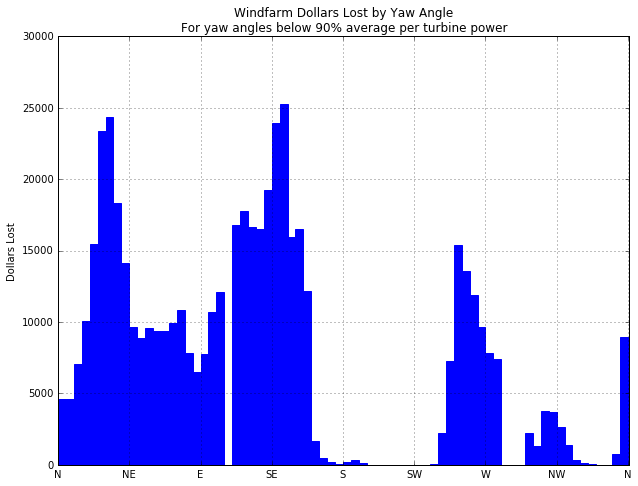

In [31]:
(fig, ax) = plt.subplots(1, 1, figsize=(10.24, 7.68))
ax.bar(totals.index.values, 0 - totals['loss'], width=5, ec='b', fc='b')
ax.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
ax.set_xlim(0, 361)
ax.grid(True)
ax.set_ylabel("Dollars Lost")
ax.set_title(("Windfarm Dollars Lost by Yaw Angle\n"
             "For yaw angles below 90% average per turbine power"))
fig.savefig('farmloss_byyaw.png')
print totals['loss'].sum()

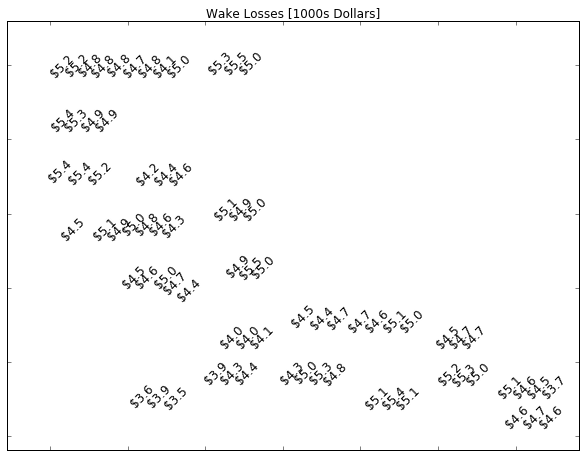

In [26]:
pgconn = psycopg2.connect(database='scada')
cursor = pgconn.cursor()
cursor.execute("""select id, lon, lat from
     turbines""")
lons = []
lats = []
vals = []
for row in cursor:
    if data.get(row[0]) is None:
        continue
    lons.append(row[1])
    lats.append(row[2])
    vals.append(data.get(row[0]) / 1000.)

(fig, ax) = plt.subplots(1, 1, figsize=(10.24, 7.68))
for v, lon, lat in zip(vals, lons, lats):
    ax.text(lon, lat, "$%.1f" % (v,), rotation=45, fontsize=12)

ax.set_xlim(min(lons)-0.01, max(lons)+0.01)
ax.set_ylim(min(lats)-0.01, max(lats)+0.01)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_title("Wake Losses [1000s Dollars]")

fig.savefig('farmloss_map.png')


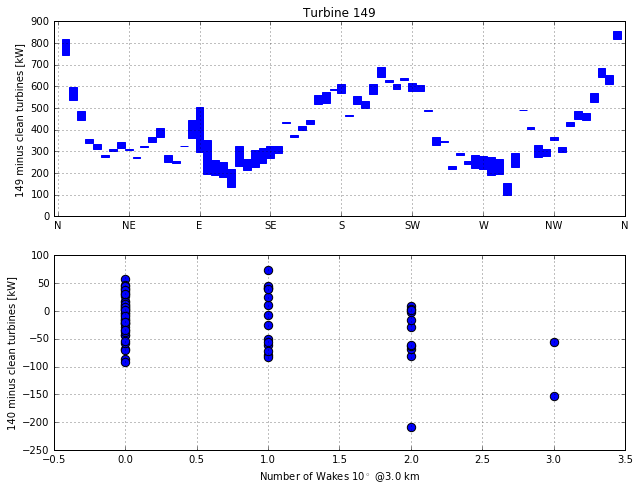

In [25]:
from pandas.io.sql import read_sql
cursor = pgconn.cursor()

turbineid = 149

# compute the number of wakes at each yaw
distance = 3000
radius = 5  # half of the fan opening
wakes = []
for azimuth in range(0, 361, 5):
    a0 = azimuth - radius
    a1 = azimuth + radius
    if a0 < 0:
        a = "(azimuth > %s or azimuth < %s)" % (360 + a0, a1)
    elif a1 >= 360:
        a = "(azimuth > %s or azimuth < %s)" % (a0, a1 - 360)
    else:
        a = "azimuth between %s and %s" % (a0, a1)

    cursor.execute("""
        SELECT count(*) from shadow where """ + a + """
        and distance < %s and bid = %s
    """, (distance, turbineid))
    wakes.append(cursor.fetchone()[0])
wakedf = pd.DataFrame(dict(wakes=wakes), index=range(0, 361, 5))

df = read_sql("""with one as (select valid, yawangle, power from cleanpower), 
two as (select valid, yawangle, power from data where turbine_id = %s and alpha1 < 1), 
agg as (select o.valid, o.power as opower, o.yawangle, t.power as tpower
from one o JOIN two t on (o.valid = t.valid)) 
SELECT (yawangle / 5)::int * 5 as yaw2, avg(opower) as farm, avg(tpower  - opower) from agg 
WHERE yawangle is not null GROUP by yaw2 ORDER by yaw2
""", pgconn, params=(turbineid, ), index_col='yaw2')
df['wakes'] = wakedf['wakes']

(fig, ax) = plt.subplots(2, 1, figsize=(10.24, 7.68))
ax[0].bar(df.index.values, bottom=df['farm'], height=df['avg'], width=5, fc='blue', ec='blue', align='center')
ax[0].set_xlim(-2.5, 360)
ax[0].set_ylabel("%s minus clean turbines [kW]" % (turbineid, ))
ax[0].grid(True)
ax[0].set_title("Turbine %s" % (turbineid,))
ax[0].set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
ax[0].set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])

ax[1].scatter(df['wakes'], df['avg'], s=70)
ax[1].grid(True)
ax[1].set_ylabel("140 minus clean turbines [kW]")
ax[1].set_xlabel("Number of Wakes %.0f$^\circ$ @%.1f km" % (radius*2, distance / 1000.))